En este notebook, se procesan y analizan los resultados obtenidos

In [1]:
import os
import pickle

from ast import literal_eval
from collections import Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from gensim.models import Word2Vec, FastText
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from nltk.collocations import BigramCollocationFinder, BigramAssocMeasures, TrigramCollocationFinder, TrigramAssocMeasures

EMBEDDING = 'word2vec'  # valores posibles: 'lda', 'word2vec', 'fasttext'

NUM_TOPICS=120
topics = range(0, NUM_TOPICS, 1)

TEXT_FILE_READ = 'docs/reddit_data_hate_speech_' + EMBEDDING + '.csv'
HATE_WORDS = 'docs/palabras_odio.csv'
TOPIC_TEST_FOLDER = 'docs/test/hstopic/'

os.makedirs(TOPIC_TEST_FOLDER, exist_ok=True)
np.random.seed(42)

In [2]:
reddit = pd.read_csv(TEXT_FILE_READ)
hate_words = pd.read_csv(HATE_WORDS)

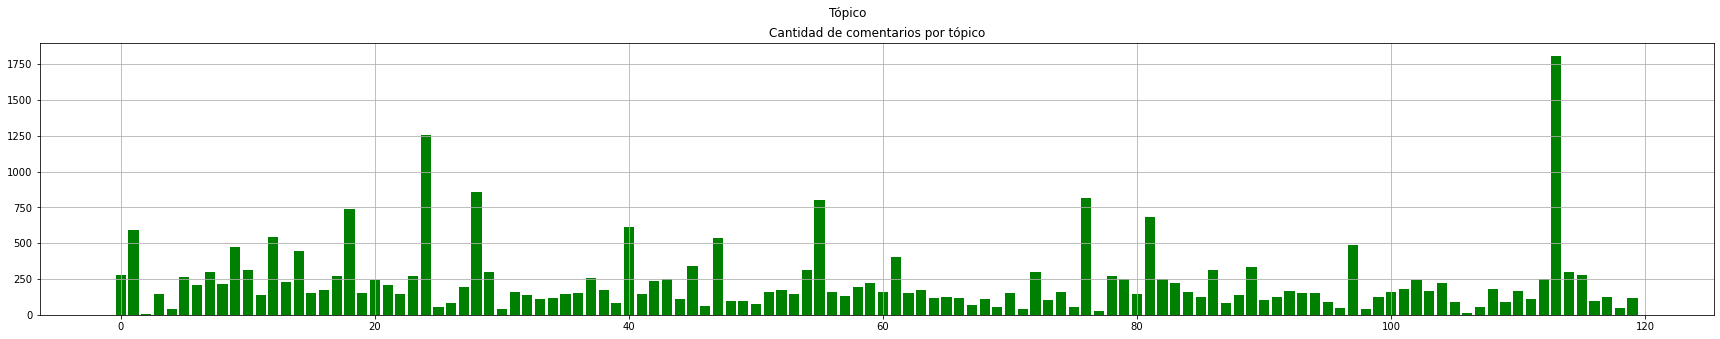

In [3]:
fig, (ax4) = plt.subplots(1, 1,figsize=(30,5))
fig.suptitle('Tópico ')

topics_range = range(0, NUM_TOPICS, 1)

topics_count = []

for i in range(NUM_TOPICS):
    temp = reddit.loc[(reddit["cluster"] == str([i]))]
    topics_count.append(len(temp))
    
ax4.bar(topics_range, topics_count, color=['green'])
ax4.set_title('Cantidad de comentarios por tópico')
ax4.grid(True)

In [4]:
def get_counts_words(reddit):
    words_hate_speech = []

    for sent in reddit['body_preprocessing']:
        for word in str(sent).split():
            words_hate_speech.append(word)
    return Counter(words_hate_speech)

In [5]:
def get_pmi_por_cluster(selected_cluster, hate_speech, minimum_word_occurrences=10):
    reddit_words_hate = reddit[(reddit["cluster"] == str([selected_cluster])) &
                      (reddit["hate_speech"]=="si")]['lemma_tokens'].apply(literal_eval)
    reddit_words_counter_hate = Counter(sum(list(reddit_words_hate),[]))
    
    word_pmis = {}

    total_msgs = len(reddit['body_preprocessing']) - reddit['body_preprocessing'].isnull().value_counts()[1]

    for word in reddit_words_counter_hate:
    
        try:
            p_non_hate_msg_without_word = reddit[reddit["hate_speech"]=="no"]['body_preprocessing'].str.contains(word).value_counts()[0] / total_msgs
            p_hate_msg_without_word = reddit[reddit["hate_speech"]=="si"]['body_preprocessing'].str.contains(word).value_counts()[0] / total_msgs
            p_non_hate_msg_with_word = reddit[reddit["hate_speech"]=="no"]['body_preprocessing'].str.contains(word).value_counts()[1] / total_msgs
            p_hate_msg_with_word = reddit[reddit["hate_speech"]=="si"]['body_preprocessing'].str.contains(word).value_counts()[1] / total_msgs
        except:
            continue

        if (p_non_hate_msg_with_word + p_hate_msg_with_word)*total_msgs >= minimum_word_occurrences:
            
            if hate_speech == "si":
                word_pmis[word] = np.log2(p_hate_msg_with_word / ((p_non_hate_msg_with_word + p_hate_msg_with_word) * (p_hate_msg_without_word + p_hate_msg_with_word)))
            elif hate_speech == "no":
                word_pmis[word] = np.log2(p_non_hate_msg_with_word / ((p_non_hate_msg_with_word + p_hate_msg_with_word) * (p_hate_msg_without_word + p_hate_msg_with_word)))
            else:
                raise ValueError("Se pasó un argumento desconocido para obtener pmi")

    return word_pmis

In [6]:
#type_analysis: el tipo de análisis hace referencia a como se analizan las palabras en cada cluster. 0 es por frecuencia; 1 es por información mutua.
def plot_word_cloud(topic_list, type_analysis='freq'):
    data = {'topic': [], 'score_hate_speech': [], 'score_not_hate_speech': [], 'comms_num_hate_speech': [], 'comms_num_not_hate_speech': []}
    df_marks = pd.DataFrame(data)
    
    for topic in topic_list:
        reddit_hate_speech = reddit.loc[(reddit["cluster"] == str([topic])) & (reddit["hate_speech"] == "si")]
        reddit_not_hate_speech = reddit.loc[(reddit["cluster"] == str([topic])) & (reddit["hate_speech"] == "no")]

        reddit_hate_speech.to_csv(TOPIC_TEST_FOLDER + str(topic) + '_hp.csv')
        reddit_not_hate_speech.to_csv(TOPIC_TEST_FOLDER + str(topic) + '_nhp.csv')

        if len(reddit_hate_speech) > 0 or len(reddit_not_hate_speech) > 0:
            types = ['Hate Speech','Not Hate Speech']
            score = [reddit_hate_speech['score'].mean(),reddit_not_hate_speech['score'].mean()]
            num_comments = [reddit_hate_speech['comms_num'].mean(),reddit_not_hate_speech['comms_num'].mean()]
            New_Colors = ['red','blue']

            fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5,figsize=(30,5))
            fig.suptitle('Tópico ' + str(topic))

            if len(reddit_hate_speech) > 0:
                if type_analysis == 'freq':
                    ax1.imshow(WordCloud(random_state=1, max_words=20, background_color='black', colormap='Set2', collocations=False, stopwords=STOPWORDS)
                               .fit_words(get_counts_words(reddit_hate_speech)))
                elif type_analysis == 'pmi':
                    words = get_pmi_por_cluster(topic, "si")
                    if len(words) > 0:
                        ax1.imshow(WordCloud(random_state=1, max_words=20, background_color='black', colormap='Set2', collocations=False, stopwords=STOPWORDS)
                               .fit_words(words))

                else:
                    raise ValueError('Se pasó una configuración de nube de palabras no definida')

            ax1.axis("off")
            ax1.set_title('Palabras Hate Speech')

            if len(reddit_not_hate_speech) > 0:
                if type_analysis == 'freq':
                    ax2.imshow(WordCloud(random_state=1, max_words=20, background_color='navy', colormap='rainbow', collocations=False, stopwords=STOPWORDS)
                           .fit_words(get_counts_words(reddit_not_hate_speech)))
                elif type_analysis == 'pmi':
                    words = get_pmi_por_cluster(topic, "no")
                    if len(words) > 0:
                        ax2.imshow(WordCloud(random_state=1, max_words=20, background_color='navy', colormap='rainbow', collocations=False, stopwords=STOPWORDS)
                               .fit_words(words))
                else:
                    raise ValueError('Se pasó una configuración de nube de palabras no definida')

            ax2.axis("off")
            ax2.set_title('Palabras Not Hate Speech')

            ax3.bar(types, score, color=New_Colors)
            ax3.set_title('Puntaje promedio')
            ax3.grid(True)

            ax4.bar(types, num_comments, color=New_Colors)
            ax4.set_title('Números de comentarios promedio')
            ax4.grid(True)

            ax5.bar(types, [len(reddit_hate_speech), len(reddit_not_hate_speech)], color=New_Colors)
            ax5.set_title('Números de comentarios Clasificador por odio y no odio')
            ax5.grid(True)

            new_row = {'topic':topic, 'score_hate_speech':score[0], 'score_not_hate_speech':score[1], 'comms_num_hate_speech':num_comments[0], 'comms_num_not_hate_speech':num_comments[1]}
            df_marks = df_marks.append(new_row, ignore_index=True)
        else:
            print('No tiene palabras')
    
    return df_marks

In [7]:
def calcular_distancias(topic_list, model, kmeans):
    distances = {}
    
    for word in pd.Series([hate_words['hateval_rf'], hate_words['hateval_nb'],
                    hate_words['detoxis_rf'], hate_words['detoxis_nb'],
                    hate_words['meoffendmex_rf'], hate_words['meoffendmex_nb']]).iloc[0]:
        word_distance_per_topic = []
        for topic in topic_list:
            try:
                word_distance_per_topic.append(np.linalg.norm(model.wv.get_vector(word) - kmeans.cluster_centers_[topic]))
            except KeyError:
                word_distance_per_topic.append(np.inf)
        distances[word] = word_distance_per_topic
    
    return distances

In [8]:
def ver_palabras_asociadas(palabras_asociadas, embedding, clustering_model):
    for palabra_asociada in palabras_asociadas:
        print('Palabra: {}'.format(palabra_asociada))
        print('Clúster: {}'.format(clustering_model.predict(np.array([embedding.wv.get_vector(palabra_asociada)], dtype=float))))
        print('Términos cercanos: {} \n'.format(embedding.wv.most_similar(palabra_asociada)))

Los vemos en nube de palabras en base a las detecciones del modelo:

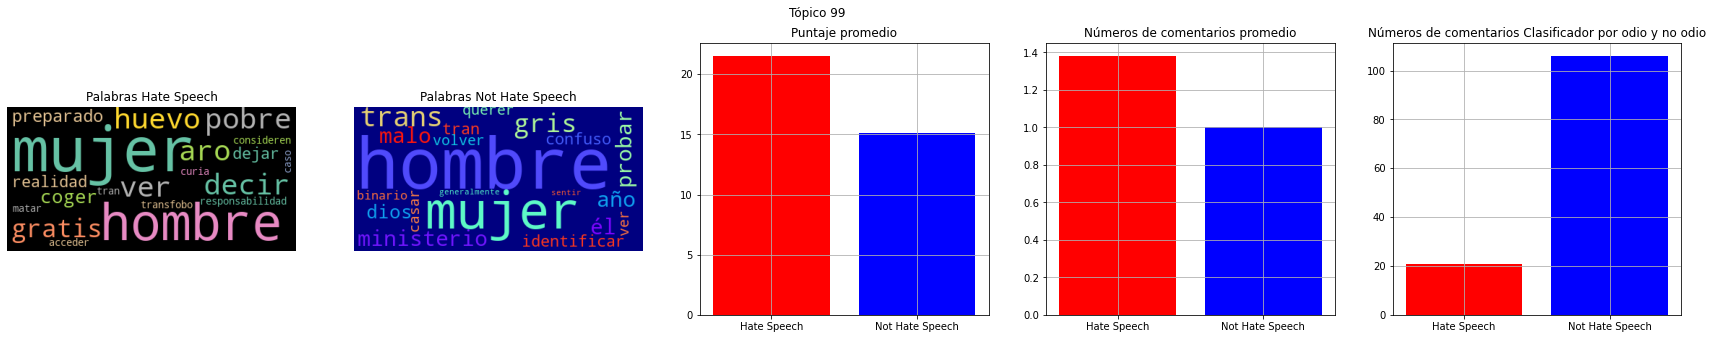

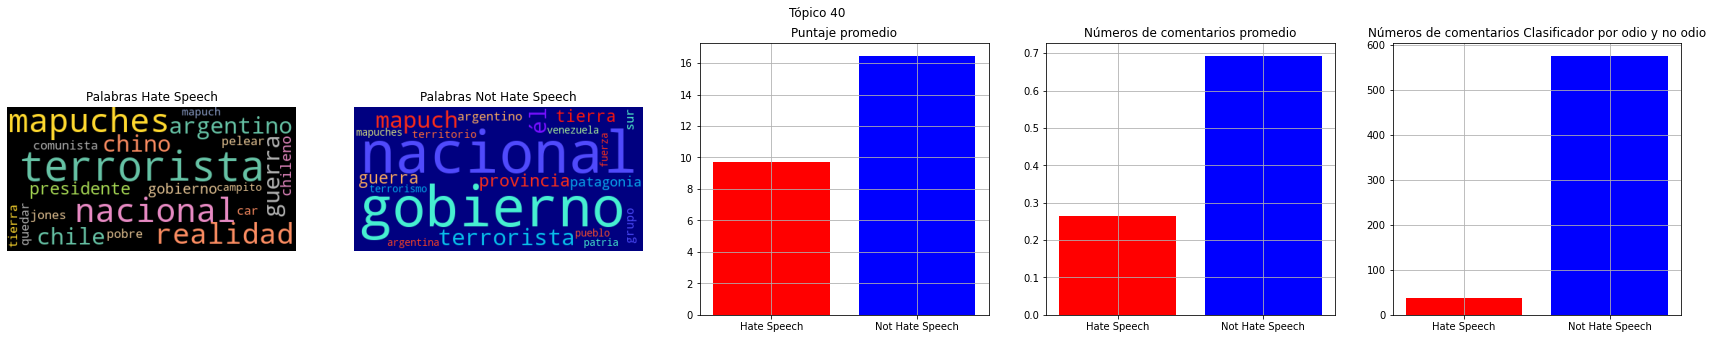

In [12]:
# algunos tópicos interesantes: [8, 13, 14, 18, 23, 44, 53, 59, 61, 64, 72, 73, 87, 94, 98, 99, 100, 104, 114]
# topicos hand-picked = [8 (economía), 18 (política), 99 (mujeres), 94 (leyes), 73]

#df_marks = plot_word_cloud(np.arange(0, 119, 1), "freq")
df_marks = plot_word_cloud([99,40], "freq")

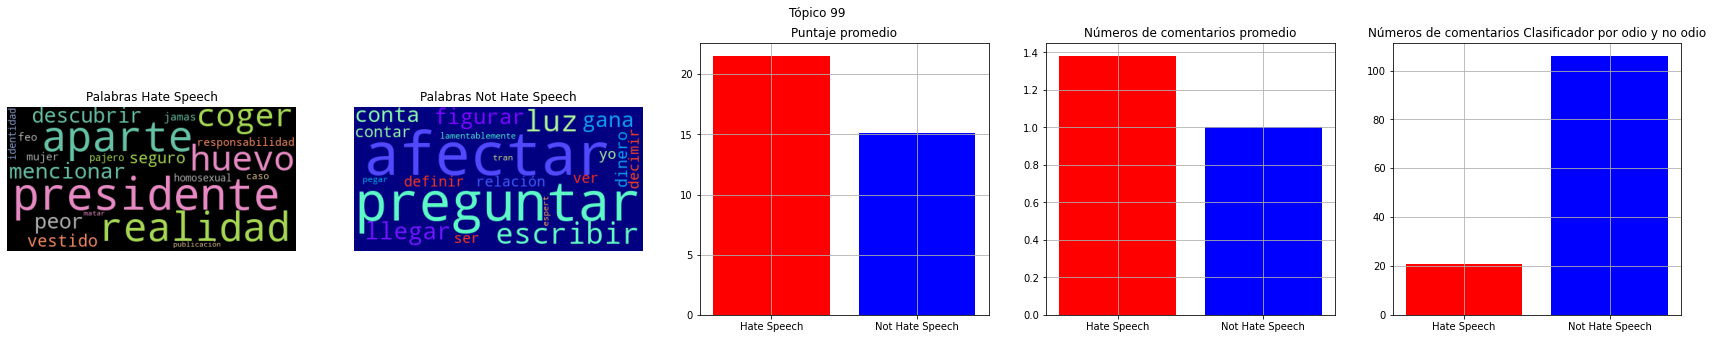

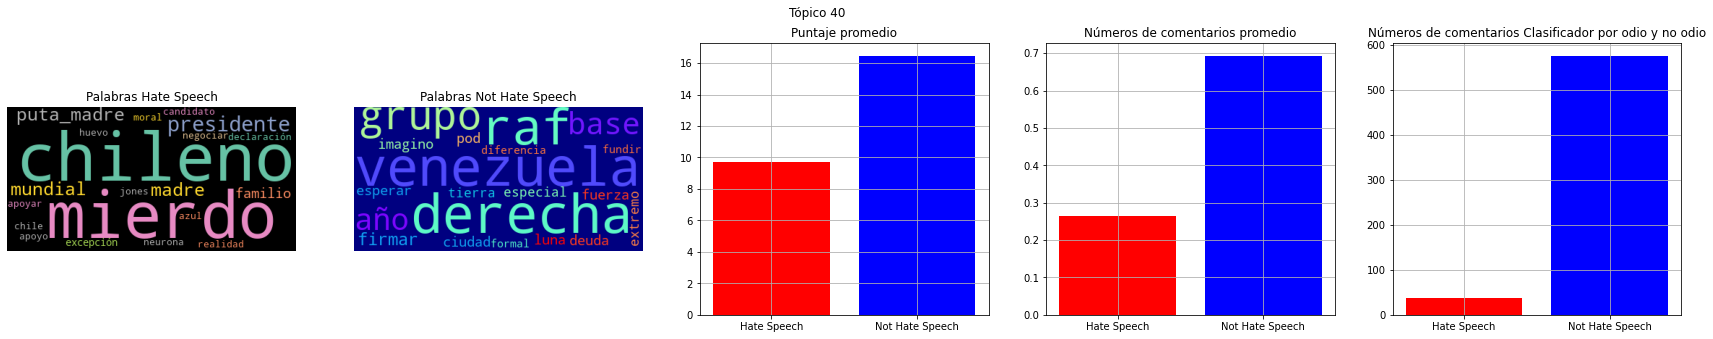

In [13]:
df_marks = plot_word_cloud([99,40], "pmi")

In [11]:
df_marks.describe()

,topic,score_hate_speech,score_not_hate_speech,comms_num_hate_speech,comms_num_not_hate_speech
count,6.000000,6.000000,6.000000,6.000000,6.000000
mean,65.166667,15.740233,16.267487,0.845979,0.785613
std,41.652931,5.428011,2.269601,0.416575,0.194855
min,8.000000,8.666667,13.124138,0.500000,0.500000
25%,31.750000,11.650528,15.132075,0.588908,0.685258
50%,83.500000,15.988556,16.191038,0.615317,0.775000
75%,97.750000,20.549107,17.334559,1.191964,0.950000
max,99.000000,21.523810,19.603886,1.380952,1.000000


### Cherry picking

In [12]:

selected_cluster = 17

reddit_words_all = reddit[reddit["cluster"] == str([selected_cluster])]['lemma_tokens'].apply(literal_eval)
reddit_words_hate = reddit[(reddit["cluster"] == str([selected_cluster])) &
                      (reddit["hate_speech"]=="si")]['lemma_tokens'].apply(literal_eval)
bigram_finder = BigramCollocationFinder.from_documents(reddit_words_all)
trigram_finder = TrigramCollocationFinder.from_documents(reddit_words_all)
bigram_finder.apply_freq_filter(2)  # limitamos la cantidad mínima de palabras que deben aparecer
trigram_finder.apply_freq_filter(2)

In [13]:
word_pmis = {}
hate_speech = "si"
total_msgs = len(reddit['body_preprocessing']) - reddit['body_preprocessing'].isnull().value_counts()[1]
minimum_word_occurrences = 10

reddit_words_hate = reddit[(reddit["cluster"] == str([selected_cluster])) &
                  (reddit["hate_speech"]=="si")]['lemma_tokens'].apply(literal_eval)
reddit_words_counter_hate = Counter(sum(list(reddit_words_hate),[]))

for word in reddit_words_counter_hate:
    
    try:
        p_non_hate_msg_without_word = reddit[reddit["hate_speech"]=="no"]['body_preprocessing'].str.contains(word).value_counts()[0] / total_msgs
        p_hate_msg_without_word = reddit[reddit["hate_speech"]=="si"]['body_preprocessing'].str.contains(word).value_counts()[0] / total_msgs
        p_non_hate_msg_with_word = reddit[reddit["hate_speech"]=="no"]['body_preprocessing'].str.contains(word).value_counts()[1] / total_msgs
        p_hate_msg_with_word = reddit[reddit["hate_speech"]=="si"]['body_preprocessing'].str.contains(word).value_counts()[1] / total_msgs
    except:
        continue

    if (p_non_hate_msg_with_word + p_hate_msg_with_word)*total_msgs >= minimum_word_occurrences:

        if hate_speech == "si":
            word_pmis[word] = np.log2(p_hate_msg_with_word / ((p_non_hate_msg_with_word + p_hate_msg_with_word) * (p_hate_msg_without_word + p_hate_msg_with_word)))
        elif hate_speech == "no":
            word_pmis[word] = np.log2(p_non_hate_msg_with_word / ((p_non_hate_msg_with_word + p_hate_msg_with_word) * (p_hate_msg_without_word + p_hate_msg_with_word)))
        else:
            raise ValueError("Se pasó un argumento desconocido para obtener pmi")

In [14]:
word_pmis_sorted = sorted(word_pmis.items(),key=lambda x:x[1], reverse=True)
word_pmis_sorted[:30]

[('pario', 2.7433825929662747),
 ('mierdo', 2.6806468376183124),
 ('mierda', 2.589348964293854),
 ('mierdar', 2.5665048308821956),
 ('puto', 2.470364098559859),
 ('simio', 2.46327467377354),
 ('hdp', 2.400990395519197),
 ('presidente', 2.3910808490353936),
 ('puta_madre', 2.3897456383515743),
 ('gordo', 2.374148783300556),
 ('madre', 2.3497187444799983),
 ('concha', 2.212867876267495),
 ('cagón', 2.1584200922451187),
 ('petiso', 2.0064169988000686),
 ('culo', 2.0023008903278368),
 ('ponetir', 1.8364919973577565),
 ('realidad', 1.8173831744100517),
 ('huevo', 1.7999661213326423),
 ('viejo', 1.7207811640291422),
 ('naaa', 1.5209901716298269),
 ('falso', 1.4632746737735394),
 ('descartar', 1.4214544980789123),
 ('jubilado', 1.4214544980789123),
 ('aval', 1.4214544980789123),
 ('serial', 1.4214544980789123),
 ('apreciar', 1.4214544980789123),
 ('edificio', 1.4214544980789123),
 ('pelotudo', 1.3573241606591968),
 ('paso', 1.3261475379831846),
 ('ignorante', 1.3104231856901685)]

In [15]:
word2vec_model = Word2Vec.load('docs/models/word2vec.model')
fasttext_model = FastText.load('docs/models/fasttext.model')

with open('docs/models/word2vec_kmeans.model', 'rb') as f:
    word2vec_kmeans = pickle.load(f)
    
with open('docs/models/fasttext_kmeans.model', 'rb') as f:
    fasttext_kmeans = pickle.load(f)

In [16]:
ver_palabras_asociadas([word_pmis_sorted[i][0] for i in range(10)], word2vec_model, word2vec_kmeans)

Palabra: pario
Clúster: [116]
Términos cercanos: [('pobretonto', 0.7889789938926697), ('palmó', 0.7833644151687622), ('ramen', 0.7613103985786438), ('escoger', 0.7466124296188354), ('comper', 0.7394694089889526), ('carpinchistico', 0.7357847094535828), ('kjjjjjjjjjjj', 0.7342244386672974), ('podrida', 0.7176601886749268), ('anfeta', 0.6871074438095093), ('refuta', 0.6751058101654053)] 

Palabra: mierdo
Clúster: [17]
Términos cercanos: [('nefasto', 0.4003210961818695), ('mierda', 0.3582106828689575), ('cabeza', 0.3461567163467407), ('imagina', 0.3386628031730652), ('lamentablemente', 0.33285757899284363), ('culpar', 0.3291051685810089), ('año', 0.32903388142585754), ('vuelvepartido', 0.3284968435764313), ('democracia', 0.3254987299442291), ('pidan', 0.3190957009792328)] 

Palabra: mierda
Clúster: [17]
Términos cercanos: [('banca', 0.4168201982975006), ('ganaba', 0.3647879660129547), ('mierdo', 0.35821065306663513), ('economía', 0.355868399143219), ('bajon', 0.3554363548755646), ('larret

In [17]:
ver_palabras_asociadas([word_pmis_sorted[i][0] for i in range(10)], fasttext_model, fasttext_kmeans)

Palabra: pario
Clúster: [91]
Términos cercanos: [('ario', 0.8494244813919067), ('fario', 0.8485210537910461), ('ovario', 0.8480972647666931), ('pasario', 0.8433429002761841), ('partidario', 0.830518901348114), ('lario', 0.82918781042099), ('hario', 0.8288808465003967), ('acuario', 0.8261533379554749), ('tario', 0.820868730545044), ('becario', 0.8183266520500183)] 

Palabra: mierdo
Clúster: [59]
Términos cercanos: [('mierdx', 0.8845037817955017), ('mierd', 0.8771346807479858), ('pierdo', 0.8431238532066345), ('m\\*erdo', 0.7954245209693909), ('mierdelli', 0.7953404784202576), ('mierda', 0.7920945882797241), ('miercol', 0.7763689756393433), ('mierdar', 0.7339200377464294), ('mier', 0.7313688397407532), ('lerdo', 0.7219255566596985)] 

Palabra: mierda
Clúster: [59]
Términos cercanos: [('mierdx', 0.9396186470985413), ('mierd', 0.9311040043830872), ('mierdelli', 0.8570907115936279), ('mierdaaaa', 0.8506362438201904), ('mierdar', 0.8308877944946289), ('pierda', 0.8220406174659729), ('m*erda'